In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.set_device(0)
from fastai import *
from fastai.conv_learner import *
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

In [3]:
IMG = Path('/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/')
# STYLE_IMG = IMG/'002036.jpg'
# TARGET_IMG = IMG/'003271.jpg'
! wget "https://cdn.shopify.com/s/files/1/0889/4322/products/starry-night.jpg?v=1503698473" -O "$IMG/style.jpg"
STYLE_IMG = IMG/'style.jpg'
! wget "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1Z9BqfGkh269C-mCpSiAn75-0aQE7jaMfKp6LPjgVohjMzCDxiQ" -O "$IMG/target.jpg"
TARGET_IMG = IMG/'target.jpg'

--2018-04-30 03:22:53--  https://cdn.shopify.com/s/files/1/0889/4322/products/starry-night.jpg?v=1503698473
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.34.110, 2a04:4e42:2f::622
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.34.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148749 (145K) [image/jpeg]
Saving to: ‘/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg’

100%[======================================>] 148,749     --.-K/s   in 0.006s  

2018-04-30 03:22:53 (24.8 MB/s) - ‘/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg’ saved [148749/148749]

--2018-04-30 03:22:53--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1Z9BqfGkh269C-mCpSiAn75-0aQE7jaMfKp6LPjgVohjMzCDxiQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.12.238, 2607:f8b0:4004:807::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.12.238|:443... connected.
HTTP request sent

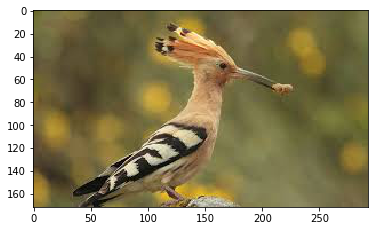

In [151]:
plt.imshow(plt.imread(TARGET_IMG)) 

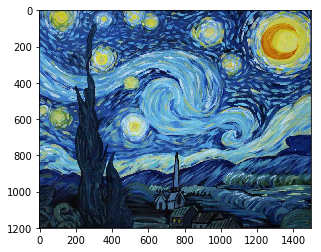

In [152]:
plt.imshow(plt.imread(STYLE_IMG))

In [4]:
sz = (224, 224)
model = to_gpu(vgg16(True).eval())
set_trainable(model, False)

In [39]:
def torch2npimg(img):
    return np.transpose(img, (1, 2, 0))

def np2torchimg(img):
    return np.transpose(img, (2, 0, 1))

def read_img(fpath, sz=sz):
    img = Image.open(fpath)
    img = np.asarray(img.resize(sz))/255
    #trn_tfms, val_tfms = tfms_from_model(vgg16, sz[0])
    #img_tfm = val_tfms(img)
    return np2torchimg(img) #img_tfm

def plot_img(torchimg, ax=None, figsize=(12, 12)):
    if len(torchimg.shape) == 4:
        torchimg = torchimg.squeeze()
    img = torch2npimg(to_np(torchimg))
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
style_img = read_img(STYLE_IMG).astype('float')
target_img = read_img(TARGET_IMG).astype('float')
trn_tfms, val_tfms = tfms_from_model(vgg16, sz[0])

## Convert Random Image to Target Image

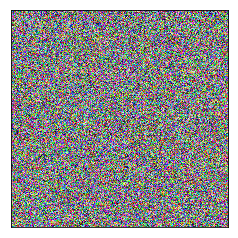

In [101]:
np.random.seed(123)
rnd_img = np.random.random((3, 224, 224)).astype('float')
plot_img(rnd_img)

In [102]:
rnd_img = V(rnd_img)
target_img = V(target_img)
rnd_img.requires_grad = True

In [91]:
def mse_loss(gen, target, scale=1):
    return scale*F.mse_loss(gen, target)

In [104]:
opt = optim.Adam([rnd_img], lr=0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

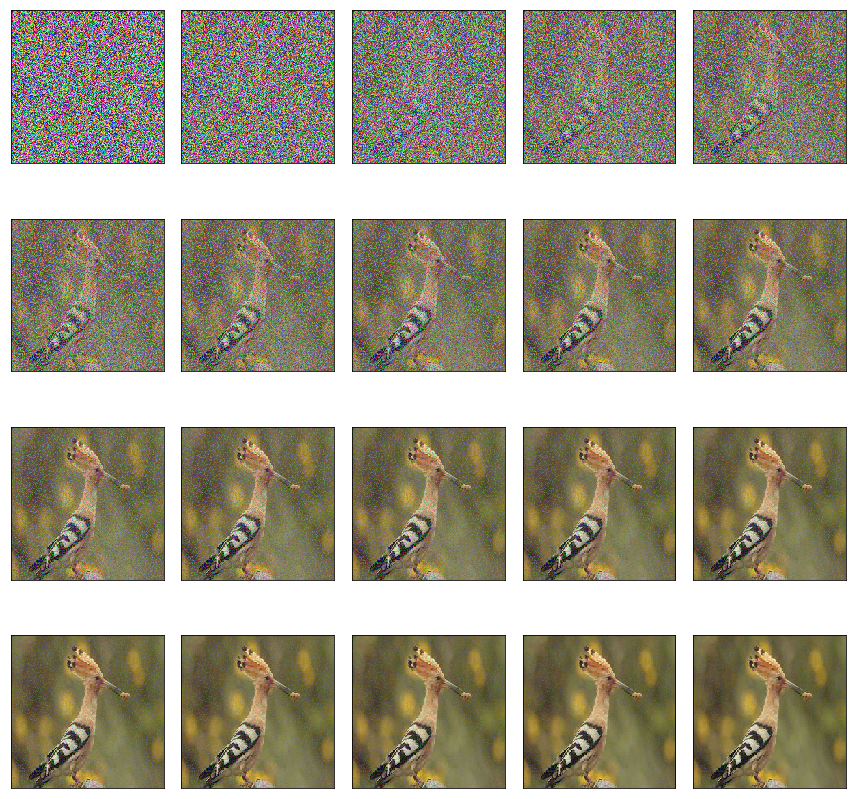

In [105]:
fig, axis = plt.subplots(4, 5, figsize=(12, 12))
plt_idx = 0
for n in range(1000):
    opt.zero_grad()
    loss = mse_loss(rnd_img, target_img)
    if n % 50 == 0:
        row = plt_idx // 5
        col = plt_idx % 5
        plot_img(rnd_img, axis[row, col])
        plt_idx += 1
    loss.backward()
    opt.step()
plt.tight_layout()

## Content Loss

In [156]:
loi = 21
inter = nn.Sequential(*list(model.children())[0:loi])
inter = to_gpu(inter).eval()
set_trainable(inter, False)

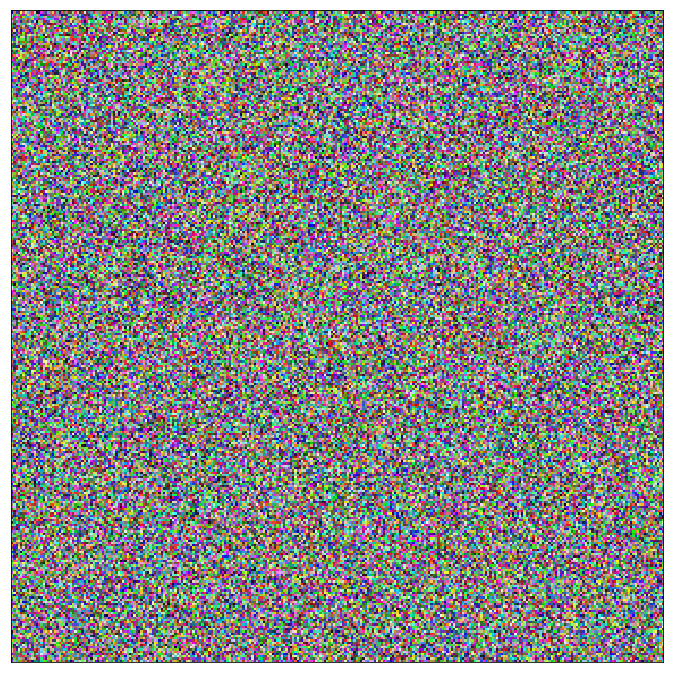

In [157]:
np.random.seed(345)
rnd_img = np.random.random((1, 3, 288, 288)).astype('float')
rnd_img = V(rnd_img)
plot_img(rnd_img)
rnd_img.requires_grad = True

In [158]:
niter = 1500
opt = optim.Adam([rnd_img])
target_act = inter(V(target_img).unsqueeze(0))

In [159]:
for n in range(niter):
    opt.zero_grad()
    gen_act = inter(rnd_img)
    loss = mse_loss(gen_act, target_act)
    loss.backward()
    opt.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


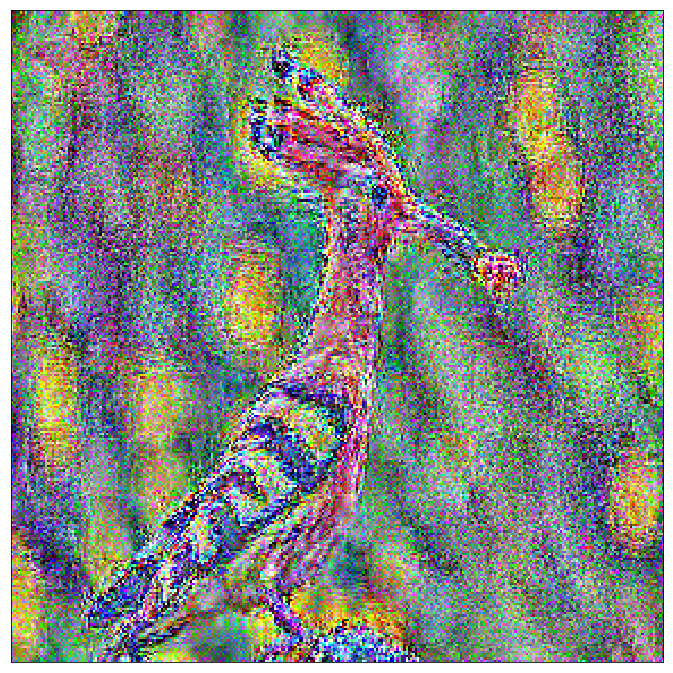

In [160]:
plot_img(rnd_img)

## Content Loss with Hooks

In [6]:
class SaveFeatures(object):
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output
        
    def close(self):
        self.hook.remove()

In [7]:
loi = 21
model.eval()
set_trainable(model, False)

In [8]:
sf = SaveFeatures(children(model)[loi])

In [56]:
def gen_rnd_img():
    np.random.seed(345)
    rnd_img = np.random.random((3, sz[0], sz[1])).astype('float')
    rnd_img = scipy.ndimage.filters.median_filter(rnd_img, [8,8,1])
    #trn_tfms, val_tfms = tfms_from_model(vgg16, sz[0])
    #rnd_img = val_tfms(rnd_img)
    rnd_img = np.expand_dims(rnd_img, 0)
    rnd_img = V(rnd_img)
    rnd_img.requires_grad = True
    return rnd_img

In [21]:
rnd_img = gen_rnd_img()

In [166]:
niter = 1500
opt = optim.Adam([rnd_img])
model(V(target_img).unsqueeze(0))
target_act = sf.features.clone()

In [167]:
for n in range(niter):
    opt.zero_grad()
    model(rnd_img)
    gen_act = sf.features.clone()
    loss = mse_loss(gen_act, target_act)
    if n % 100 == 0:
        print(f'Iteration {n}, Loss {loss.data[0]}')
    loss.backward()
    opt.step()

Iteration 0, Loss 0.021739428862929344
Iteration 100, Loss 0.013782006688416004
Iteration 200, Loss 0.01074895542114973
Iteration 300, Loss 0.008817103691399097
Iteration 400, Loss 0.0074033308774232864
Iteration 500, Loss 0.0063325585797429085
Iteration 600, Loss 0.0054894001223146915
Iteration 700, Loss 0.004819716792553663
Iteration 800, Loss 0.004271904472261667
Iteration 900, Loss 0.0038185904268175364
Iteration 1000, Loss 0.0034338978584855795
Iteration 1100, Loss 0.0031087512616068125
Iteration 1200, Loss 0.0028290480840951204
Iteration 1300, Loss 0.002589015755802393
Iteration 1400, Loss 0.002378402277827263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


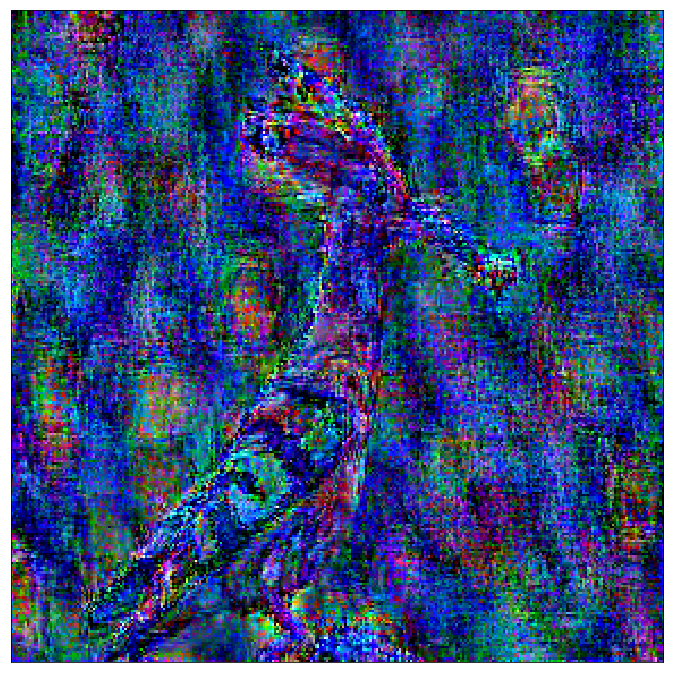

In [168]:
plot_img(rnd_img)

## Style Loss with Hooks

In [68]:
sf = [SaveFeatures(children(model)[i]) for i in [5, 12, 22, 32, 42]]

In [137]:
def gram(tens):
    tens = tens.squeeze()
    tens = tens.view(tens.shape[0], -1)
    gm = (tens @ tens.t())/tens.numel()*1e6
    return gm

In [142]:
def style_loss(x):
    model(x)
    gen_styles = [l.features.clone() for l in sf]
    losses = [F.mse_loss(gram(gen_act), gram(targ_act))
              for gen_act, targ_act in zip(gen_styles, targ_styles)]
    return sum(losses)

In [71]:
rnd_img = gen_rnd_img()

In [72]:
max_iter = 1000
opt = optim.LBFGS([rnd_img])
model(VV(np.expand_dims(style_img, 0)))
targ_styles = [l.features.clone() for l in sf]

In [75]:
def step(loss_fn):
    global n_iter
    opt.zero_grad()
    loss = loss_fn(rnd_img)
    n_iter += 1
    if n_iter % 100 == 0:
        print(f'Iteration {n_iter}, Loss {loss.data[0]}')
    loss.backward()
    return loss

In [76]:
n_iter = 0
while n_iter <= max_iter:
    opt.step(partial(step, style_loss))

Iteration 100, Loss 28.22886085510254
Iteration 200, Loss 10.278953552246094
Iteration 300, Loss 6.666729927062988
Iteration 400, Loss 5.289605140686035
Iteration 500, Loss 4.567887783050537
Iteration 600, Loss 4.035001277923584
Iteration 700, Loss 3.710671901702881
Iteration 800, Loss 3.480569362640381
Iteration 900, Loss 3.31205153465271
Iteration 1000, Loss 3.1707868576049805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


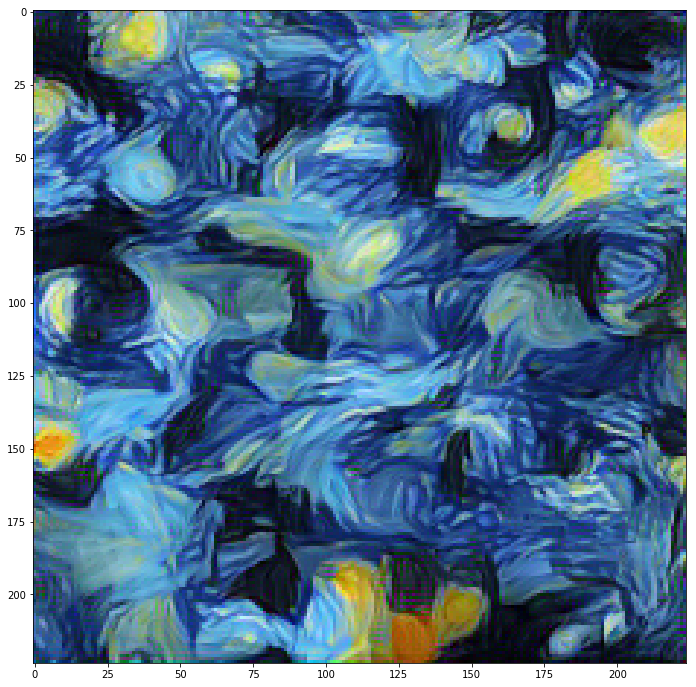

In [18]:
x = val_tfms.denorm(np.rollaxis(to_np(rnd_img), 1, 4))[0]
plt.figure(figsize=(12,12))
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


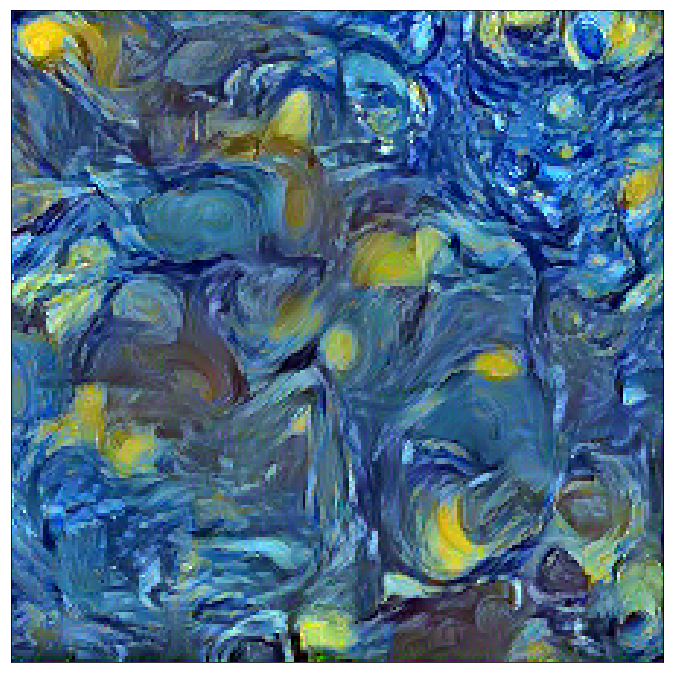

In [64]:
plot_img(rnd_img)

## Style Transfer

In [133]:
sf = [SaveFeatures(children(model)[i]) for i in [21, 5, 12, 22, 32, 42]]

In [143]:
def comb_loss(x):
    model(x)
    sl = style_loss(x)
    content_act = sf[0].features
    content_loss = mse_loss(content_act, target_act, 200)
    print(f'style: {style_loss.data[0]}, content:: {content_loss.data[0]}')
    loss = sl + content_loss
    return loss

In [144]:
rnd_img = gen_rnd_img()
max_iter = 1000
opt = optim.LBFGS([rnd_img])
model(VV(np.expand_dims(style_img, 0)))
targ_styles = [l.features.clone() for l in sf[1:]]
model(V(target_img).unsqueeze(0))
target_act = sf[0].features.clone()

In [145]:
n_iter = 0
while n_iter <= max_iter:
    opt.step(partial(step, comb_loss))

RuntimeError: input and target have different number of elements: input[256 x 256] has 65536 elements, while target[64 x 64] has 4096 elements at /pytorch/torch/lib/THCUNN/generic/MSECriterion.cu:15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


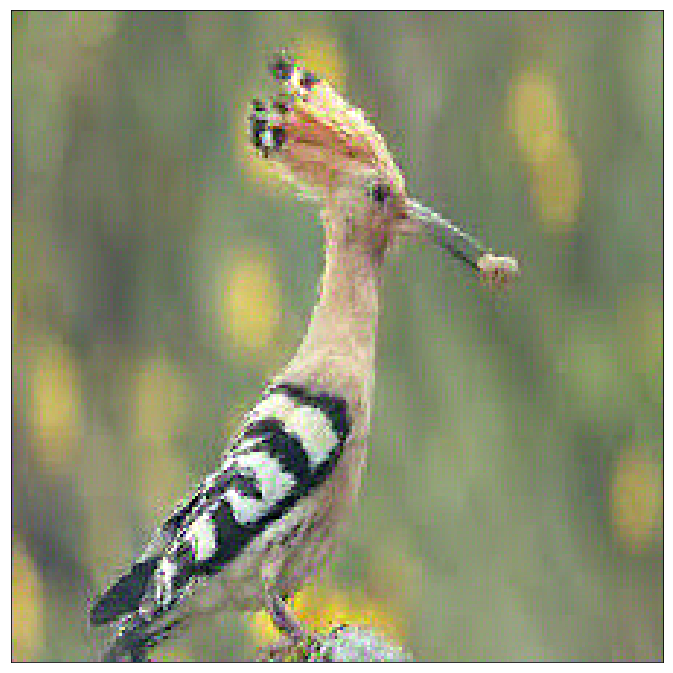

In [119]:
plot_img(rnd_img)

## Notes
Things to check:
1. Do transforms matter? Not really

Conclusiont:
1. LBGFS is way faster